# New Section

In [1]:
from google.colab import drive
drive.mount('/colab/')
# vishnu.kartikey2011

Mounted at /colab/


In [2]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout
from keras.optimizers import Adam

In [3]:
os.listdir("/colab/My Drive/")

['How to get started with Drive.pdf',
 'Colab Notebooks',
 'SelfDrivingCar',
 'Copy of model-08-0.13.h5',
 'ftrainf.csv',
 'archive (2).zip',
 '10 g maths part 1']

In [4]:
import zipfile
zip_ref = zipfile.ZipFile("/colab/My Drive/archive (2).zip", 'r')
zip_ref.extractall("/tmp")
zip_ref.close()

In [5]:
train_data = pd.read_csv('/tmp/written_name_train_v2.csv')
valid_data = pd.read_csv('/tmp/written_name_validation_v2.csv')

In [6]:
train_data

,FILENAME,IDENTITY
0,TRAIN_00001.jpg,BALTHAZAR
1,TRAIN_00002.jpg,SIMON
2,TRAIN_00003.jpg,BENES
3,TRAIN_00004.jpg,LA LOVE
4,TRAIN_00005.jpg,DAPHNE
...,...,...
330956,TRAIN_330957.jpg,LENNY
330957,TRAIN_330958.jpg,TIFFANY
330958,TRAIN_330959.jpg,COUTINHO DESA
330959,TRAIN_330960.jpg,MOURAD


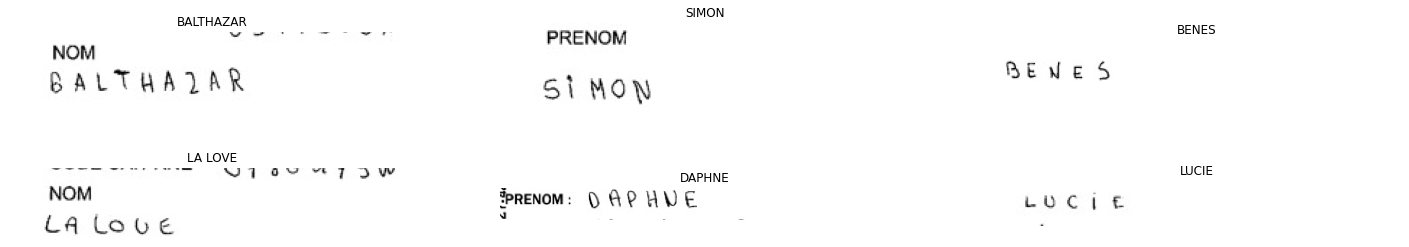

In [7]:
plt.figure(figsize=(25, 15))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = '/tmp/train_v2/train/'+train_data.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(train_data.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [8]:
if train_data['IDENTITY'].isnull().any():
  print('Nans are there in train set')
if valid_data['IDENTITY'].isnull().any():
  print('Nnas are in validation set')

Nans are there in train set
Nnas are in validation set


In [9]:
print("Number of NaNs in train set      : ", train_data['IDENTITY'].isnull().sum())
print("Number of NaNs in validation set : ", valid_data['IDENTITY'].isnull().sum())

Number of NaNs in train set      :  565
Number of NaNs in validation set :  78


In [10]:
# Nans are changed in the data frame itself
train_data.dropna(axis=0, inplace=True) 
valid_data.dropna(axis=0, inplace=True)

In [11]:
# removing unreadable text
unreadable = train_data[train_data['IDENTITY'] == 'UNREADABLE']
unreadable.reset_index(inplace = True, drop=True)
unreadable


,FILENAME,IDENTITY
0,TRAIN_00807.jpg,UNREADABLE
1,TRAIN_01220.jpg,UNREADABLE
2,TRAIN_02240.jpg,UNREADABLE
3,TRAIN_02861.jpg,UNREADABLE
4,TRAIN_08931.jpg,UNREADABLE
...,...,...
97,TRAIN_307024.jpg,UNREADABLE
98,TRAIN_308183.jpg,UNREADABLE
99,TRAIN_310107.jpg,UNREADABLE
100,TRAIN_316012.jpg,UNREADABLE


In [12]:
train_data = train_data[train_data['IDENTITY'] != 'UNREADABLE']
valid_data = valid_data[valid_data['IDENTITY'] != 'UNREADABLE']

In [13]:
# capital letters conversion of the filenames
train_data['IDENTITY'] = train_data['IDENTITY'].str.upper()
valid_data['IDENTITY'] = valid_data['IDENTITY'].str.upper()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [14]:
train_data.reset_index(inplace = True, drop=True) 
valid_data.reset_index(inplace = True, drop=True)

In [15]:
def cropping(img):
    (h, w) = img.shape
    
    final_img = np.ones([64, 256])*255 # blank white image
    
    if w > 256:
        img = img[:, :256]
        
    if h > 64:
        img = img[:64, :]
    
    
    final_img[:h, :w] = img
    return cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE)
    '''
    Here rotation of image is very important because image is rotated to be effectively fed into the lstm layer. lstm takes in the width of the image as the input of timesteps 
    and the height of image as the column feature vector in the lstm layer. Whenever we use images to be inserted in the lstm model we ensure that we are inserting width of 
    feature matrix of the image inside it. Therefore we need to rotate it by 90 degree   
    '''

In [16]:
print(train_data.shape)
print(valid_data.shape)
train_size = 80000
valid_size= 8000

(330294, 2)
(41280, 2)


In [17]:
train_x = []

for i in range(train_size):
    img_dir = '/tmp/train_v2/train/'+train_data.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = cropping(image)
    image = image/255.
    train_x.append(image)
print(np.array(train_x).shape)    

(80000, 256, 64)


In [18]:
valid_x = []

for i in range(valid_size):
    img_dir = '/tmp/validation_v2/validation/'+valid_data.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = cropping(image)
    image = image/255.
    valid_x.append(image)
print(np.array(valid_x).shape)    

(8000, 256, 64)


In [19]:
# if rotation layer abortion didnot worked change the shape back to 256, 64
train_x = np.array(train_x).reshape(-1, 256, 64, 1)
valid_x = np.array(valid_x).reshape(-1, 256, 64, 1)

In [20]:
print(train_x.shape)
print(valid_x.shape)

(80000, 256, 64, 1)
(8000, 256, 64, 1)


In [21]:
# The size of the width of the image is reduced to 64 by the CNN and then (refered in the liked video that layers should be reshaped to (width, height*no. of filters)). 
# Hence (64,8,128) is changed to (64,1024). This is then boiled down to (64,64)--> (w,dense neuron). Then matrix of CNN features is inserted to LSTM in a special fashion. 
# This is done such that every column of CNN feature matrix is punched in LSTM i.e. (n--> no. of width) is introduced inside LSTM. Now what i could figure out is that
# every column of CNN feature matrix (of rotated image) becomes an input to the LSTM architecture, Hence there will be 64 time steps(64 width in matrix) 
# Input of LSTM is written in the notes copy(BBC Compacta) which says input is (batch, timesteps, feature). Here 64 is the timesteps that is the width of the matrix. 
# Feature in the above input tuple represents column vector that will be a output from each timestep of present layer to each timestep of next layer.
# For every character (30 as above) will have 64 output predictions.  
# and then we will choose the best out of that. Now CTC is involved in it in a very beautiful way.       


alphabets = "ABCDEFGHIJKLMNOPQRSTUVWXYZ-' "
max_str_len = 34 # max length of input labels
num_of_characters = len(alphabets) + 1 # +1 for ctc pseudo blank
num_of_timestamps = 64 # max length of predicted labels


def label_to_num(label):
    label_num = []
    for ch in label:
        label_num.append(alphabets.find(ch))
        
    return np.array(label_num)

def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret+=alphabets[ch]
    return ret

In [22]:
name = 'KARTIKEY'
print(name, '\n',label_to_num(name))

KARTIKEY 
 [10  0 17 19  8 10  4 24]


In [23]:
# These vectors    TRAIN_Y,   TRAIN_INPUT_LEN,   TRAIN_LABEL_LEN  are created because they are used in ctc loss layer added in the last of the model. 
# So they are created to be used in the gtruth_layer, input_Layer, label_layer (which are analogus to TRAIN_Y,   TRAIN_INPUT_LEN,   TRAIN_LABEL_LEN) 
# which itself are an input to the ctc layer. This si the reason they are being input to the model.fit() function.

train_y = np.ones([train_size, max_str_len]) * -1
train_label_len = np.zeros([train_size, 1])
train_input_len = np.ones([train_size, 1]) * (num_of_timestamps-2)
# 64 -2 is actually output of last layer of lstm which has 64 timesteps and 2 is substracted because <start> and <end> of every sentence. So actual letter produced are 62.
train_output = np.zeros([train_size])

for i in range(train_size):
    train_label_len[i] = len(train_data.loc[i, 'IDENTITY'])
    train_y[i, 0:len(train_data.loc[i, 'IDENTITY'])]= label_to_num(train_data.loc[i, 'IDENTITY']) 

In [24]:
valid_y = np.ones([valid_size, max_str_len]) * -1
valid_label_len = np.zeros([valid_size, 1])
valid_input_len = np.ones([valid_size, 1]) * (num_of_timestamps-2)
valid_output = np.zeros([valid_size])

for i in range(valid_size):
    valid_label_len[i] = len(valid_data.loc[i, 'IDENTITY'])
    valid_y[i, 0:len(valid_data.loc[i, 'IDENTITY'])]= label_to_num(valid_data.loc[i, 'IDENTITY']) 

In [25]:
print('True label : ',train_data.loc[100, 'IDENTITY'] , '\ntrain_y : ',train_y[100],'\ntrain_label_len : ',train_label_len[100], 
      '\ntrain_input_len : ', train_input_len[100])

True label :  NOUR 
train_y :  [13. 14. 20. 17. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.] 
train_label_len :  [4.] 
train_input_len :  [62.]


In [26]:
max(train_label_len)

array([34.])

In [27]:
input_data = Input(shape=(256, 64, 1), name='input')
# Next added line
# labels = Input(name="label", shape=(None,), dtype="float32")

inner = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)  
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)

inner = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)
inner = Dropout(0.3)(inner)

inner = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)
inner = Dropout(0.3)(inner)

inner = Reshape(target_shape=((64, 1024)), name='reshape')(inner)
inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

## lstm
inner = Bidirectional(LSTM(512, return_sequences=True), name = 'lstm1')(inner)
inner = Bidirectional(LSTM(512, return_sequences=True), name = 'lstm2')(inner)

inner = Dense(num_of_characters, kernel_initializer='he_normal',name='dense2')(inner)
y_pred = Activation('softmax', name='softmax')(inner)
# y_pred_out = CTCLayer(name="ctc_loss")(labels, x)

model = Model(inputs=input_data, outputs=y_pred)
model.summary()

''' It is very important to understand that CTC should be added as a layer in the model. Which is still not added, Hence we need to add this in another layer. 
    CTC loss also encounters 4 vectors that are listed below that should act as an input to ctc loss. ctc loss have maths that still needs to be checked.
    This si just a function. So it cannot be added directly into the sequential model. Therefore we need Lambda layer of keras to be used 
    which would add a function as layer in the model. Which is described below. '''

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 256, 64, 1)]      0         
_________________________________________________________________
conv1 (Conv2D)               (None, 256, 64, 32)       320       
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 64, 32)       128       
_________________________________________________________________
activation (Activation)      (None, 256, 64, 32)       0         
_________________________________________________________________
max1 (MaxPooling2D)          (None, 128, 32, 32)       0         
_________________________________________________________________
conv2 (Conv2D)               (None, 128, 32, 64)       18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 32, 64)       256   

In [28]:
# the ctc loss function
# y_true = tensor (samples, max_string_length) containing the truth labels.

# y_pred = tensor (samples, time_steps, num_categories) containing the prediction, or output of the softmax.

# input_length = tensor (samples, 1) containing the sequence length for each batch item in y_pred.

# label_length = tensor (samples, 1) containing the sequence length for each batch item in y_true.

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [29]:
# y_true = tensor (samples, max_string_length) containing the truth labels.

# y_pred = tensor (samples, time_steps, num_categories of alphabet) containing the prediction, or output of the softmax.

# input_length = tensor (samples, 1) containing the sequence length for each batch item in y_pred.

# label_length = tensor (samples, 1) containing the sequence length for each batch item in y_true.

labels = Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
# This input layer is filled by the train_y vector. This is why train_y is inputed in the model.fit()  
input_length = Input(name='input_length', shape=[1], dtype='int64')
# This input layer is filled by the train_input_len vector. This is why train_input_len is inputed in the model.fit()
label_length = Input(name='label_length', shape=[1], dtype='int64')
# This input layer is filled by the train_label_len vector. This is why train_label_len is inputed in the model.fit()

# LAMBDA function takes in one function and as many inputs and gives the output of the same function specified.
# Lambda layer is different from it--------> It wraps arbitary function as a layer object(part of model). You can also use (tf.keras.layers.Layer) instead of Lambda layer.
# tf.keras.layers.Lambda(function, output_shape=None, mask=None, arguments=None, **kwargs)
ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])

model_final = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)
model_final.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 256, 64, 1)] 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 256, 64, 32)  320         input[0][0]                      
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 64, 32)  128         conv1[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 64, 32)  0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [30]:
# the loss calculation occurs elsewhere, so we use a dummy lambda function for the loss
model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(lr = 0.0001), metrics = ['acc'])

# x here is all the vectors that are to be used as an input to the model and y are the target labels which is being inserted in the x =[] list vector. 
# Y here is the dummy output for the ctc loss. Same is for the validation_data.
model_final.fit(x=[train_x, train_y, train_input_len, train_label_len], y=train_output, 
                validation_data=([valid_x, valid_y, valid_input_len, valid_label_len], valid_output),
                epochs=60, batch_size=128)

Epoch 1/60
625/625 [==============================] - 135s 198ms/step - loss: 25.4578 - acc: 0.0000e+00 - val_loss: 19.5496 - val_acc: 0.0000e+00
Epoch 2/60
625/625 [==============================] - 121s 194ms/step - loss: 18.6014 - acc: 0.0000e+00 - val_loss: 16.0064 - val_acc: 0.0000e+00
Epoch 3/60
625/625 [==============================] - 120s 192ms/step - loss: 14.5003 - acc: 1.0597e-06 - val_loss: 9.5062 - val_acc: 0.0000e+00
Epoch 4/60
625/625 [==============================] - 121s 193ms/step - loss: 8.7607 - acc: 0.0019 - val_loss: 5.5037 - val_acc: 0.0342
Epoch 5/60
625/625 [==============================] - 119s 191ms/step - loss: 5.5326 - acc: 0.0397 - val_loss: 4.0258 - val_acc: 0.1507
Epoch 6/60
625/625 [==============================] - 119s 190ms/step - loss: 4.1566 - acc: 0.1336 - val_loss: 3.3014 - val_acc: 0.2769
Epoch 7/60
625/625 [==============================] - 119s 190ms/step - loss: 3.4069 - acc: 0.2445 - val_loss: 2.8270 - val_acc: 0.4001
Epoch 8/60
625/625 

In [31]:
model.save('/colab/My Drive/OCR-handwriting-saved-model/model-final-save.h5')

In [32]:
model_final.save('/colab/My Drive/OCR-handwriting-saved-model/model_final-final-save.h5')

In [33]:
# We have to predict our trained model so we used model and not model_final because model_final includes loss function and inputs required for it. 
# But here we just need output from softmax activation. So use model.  
preds = model.predict(valid_x)
decoded = K.get_value(K.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1], 
                                   greedy=True)[0][0])

prediction = []
for i in range(valid_size):
    prediction.append(num_to_label(decoded[i]))

In [34]:
y_true = valid_data.loc[0:valid_size, 'IDENTITY']
correct_char = 0
total_char = 0
correct = 0

for i in range(valid_size):
    pr = prediction[i]
    tr = y_true[i]
    total_char += len(tr)
    
    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1
            
    if pr == tr :
        correct += 1 
    
print('Correct characters predicted : %.2f%%' %(correct_char*100/total_char))
print('Correct words predicted      : %.2f%%' %(correct*100/valid_size))

Correct characters predicted : 83.86%
Correct words predicted      : 72.54%


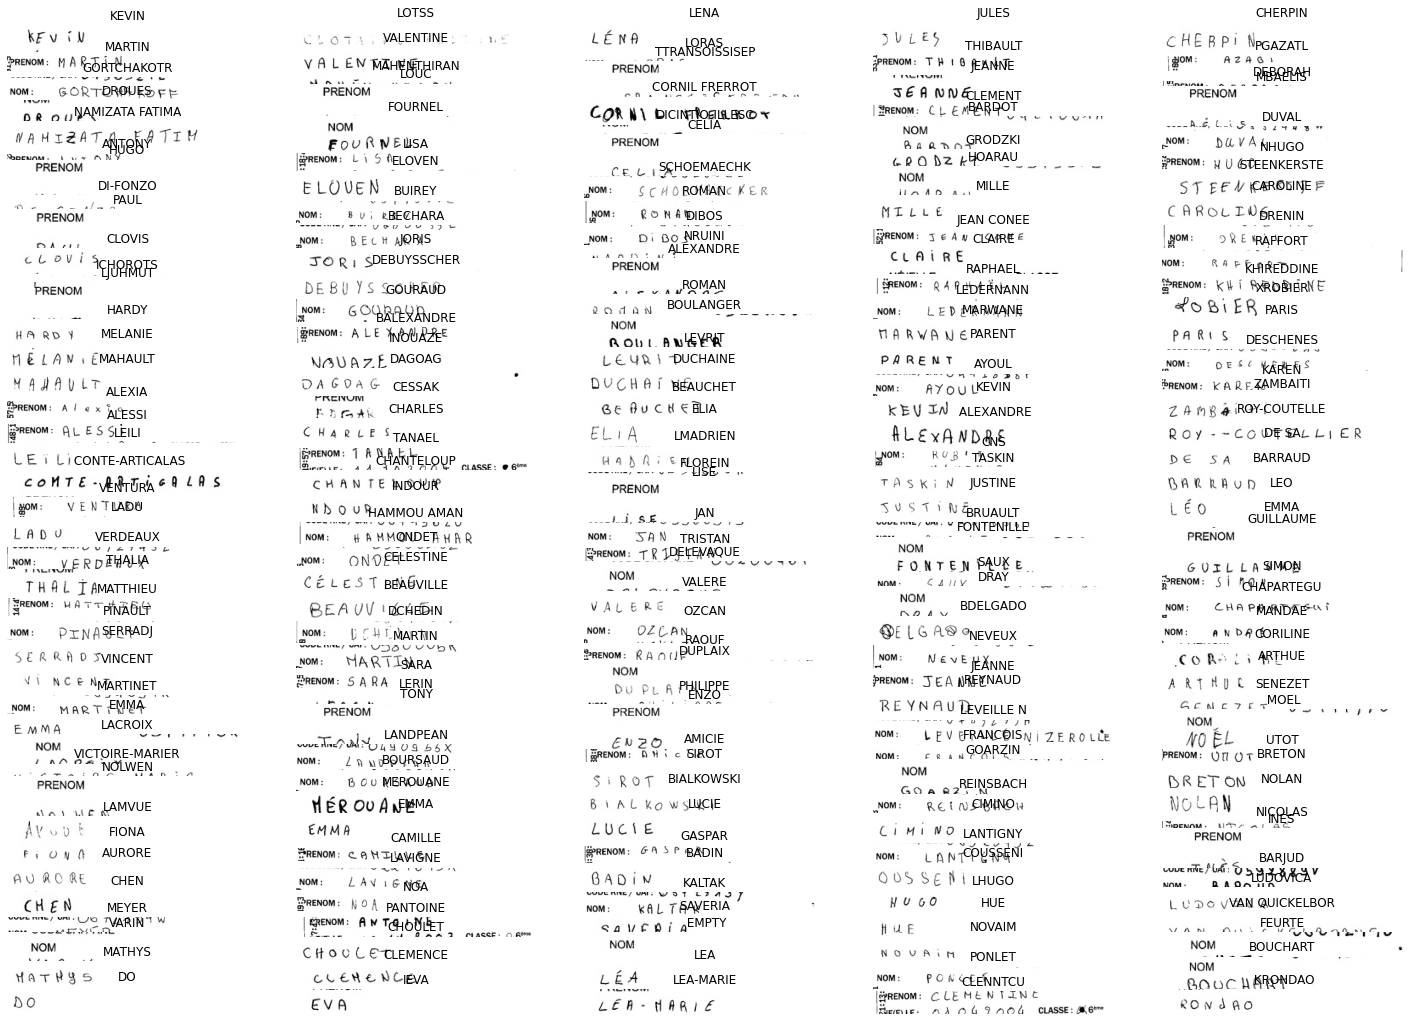

In [68]:
test = pd.read_csv('/tmp/written_name_test_v2.csv')

plt.figure(figsize=(25, 20))
for i in range(200):
    ax = plt.subplot(40, 5, i+1)
    img_dir = '/tmp/test_v2/test/'+test.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')
    
    image = cropping(image)
    image = image/255.
    pred = model.predict(image.reshape(1, 256, 64, 1))
    decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                       greedy=True)[0][0])
    plt.title(num_to_label(decoded[0]), fontsize=12)
    plt.axis('off')
    
plt.subplots_adjust(wspace=0.2, hspace=-0.8)